<a href="https://colab.research.google.com/github/am610/FRB/blob/master/FRB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install lmfit
import lmfit
import pandas as pd
import numpy as np
from scipy import integrate
from scipy.optimize import least_squares, curve_fit
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)  
from mpl_toolkits.axes_grid1 import make_axes_locatable
import io

     |████████████████████████████████| 266kB 9.1MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
     |████████████████████████████████| 235kB 29.0MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.0-cp36-none-any.whl size=87917 sha256=245792f64fe0f4f88aeb3085f96544fcdfda69bf084caa79c942e313f6d9a147
  Stored in directory: /root/.cache/pip/wheels/1f/93/e9/8d3f759e466f5bbfed3ba1d7dc5b3d4389c469a1ec9a2acaee
  Created wheel for asteval: filename=asteval-0.9.18-cp36-none-any.whl size=17381 sha256=32f1158340d5a022356d915a17cfa95ee3da3a82daef332290772217a621fc6a
  Stored in directory: /root/.cache/pip/wheels/1c/53/1b/28d929700c9633b1786a4982e6db564ec8326a8930234dcc19
  Created wheel for uncertainties: filename=uncertainties-3.1.2-cp36-none-any.whl size=96458 sha256=6f66903af18028d389fdd985e8d33ed1af02ac8b05a5ee45b79838f35bfac299
  Stored in directory: /root/.cache/pip/wheels/d9/d3/0e/5b0b743a8abd50373705427438456da5dc2621891138d7a618
Successfully built lmfit asteval uncertainties

In [0]:
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.rcParams.update({'font.size': 10})
#plt.rcParams['figure.figsize'] = [20,10] # Use this to change the plot size

In [0]:
from google.colab import files
uploaded = files.upload()


Saving galaxy_model.csv to galaxy_model.csv


In [0]:

spark = pd.read_csv(io.BytesIO(uploaded['galaxy_model.csv']),delimiter=r"\s+")

In [0]:
spark

,ID,M2L,e_M2L,M2Lb,T,D,e_D,inc,e_inc,L[3.6],e_L[3.6],Lbulge,Reff,Rp,SBeff,e_SBeff,Rdisk,SB0,e_SB0,Mbar,e_Mbar,SBbar,e_SBbar,Vp,e_Vp,Vb,e_Vb
0,CamB,0.11,0.000,0.0,10,3.36,0.26,65.0,5.0,0.075,0.003,0.0,1.21,1.22,3.334,0.123,0.47,2.960,0.037,0.01,0.000,2.754,0.110,16.8,1.50,9.940,0.000
1,D512-2,2.37,0.093,0.0,10,15.20,4.56,56.0,10.0,0.325,0.022,0.0,2.37,1.92,5.156,0.501,1.24,124.589,4.908,0.77,0.060,156.824,12.282,33.5,2.71,33.240,0.632
2,D564-8,2.37,0.558,0.0,10,8.79,0.28,63.0,7.0,0.033,0.004,0.0,0.72,1.53,4.590,0.254,0.61,22.740,5.353,0.08,0.021,14.098,3.733,21.9,1.82,15.364,1.500
3,D631-7,0.92,0.000,0.0,10,7.72,0.18,59.0,3.0,0.196,0.009,0.0,1.22,1.80,10.780,0.291,0.70,54.594,0.027,0.18,0.008,41.805,1.920,30.9,2.22,27.771,0.000
4,DDO064,2.19,0.195,0.0,10,6.80,2.04,60.0,5.0,0.157,0.007,0.0,1.20,2.08,8.705,0.379,0.69,165.982,14.813,0.34,0.034,29.025,2.896,46.9,8.65,34.414,1.035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,UGC12632,3.44,0.154,0.0,9,9.77,2.93,46.0,3.0,1.301,0.030,0.0,3.94,6.40,9.093,0.331,2.42,159.864,7.134,4.48,0.225,29.577,1.486,73.1,2.79,60.031,1.211
171,UGC12732,3.27,0.000,0.0,9,13.20,4.00,39.0,6.0,1.667,0.048,0.0,3.12,6.72,20.859,1.694,1.98,305.660,0.081,5.44,0.157,17.213,0.496,98.0,3.18,65.602,0.000
172,UGCA281,1.62,0.052,0.0,11,5.68,0.28,67.0,3.0,0.194,0.007,0.0,1.57,0.74,4.884,0.100,1.72,7.609,0.244,0.31,0.015,429.422,20.692,27.5,1.59,24.303,0.333
173,UGCA442,7.00,1.214,0.0,9,4.35,0.22,64.0,7.0,0.140,0.005,0.0,1.71,2.96,3.332,0.178,1.18,356.196,61.769,0.98,0.173,83.873,14.850,49.0,1.91,41.699,2.570


Text(0.5, 0, 'M_bar')

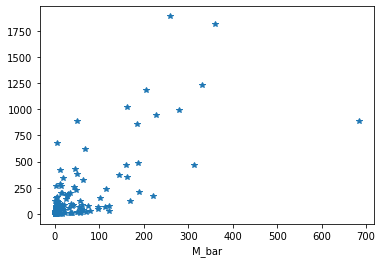

In [0]:
plt.plot(spark['Mbar'],spark['Reff']**3,'*')
#plt.xlim(-5,200)
plt.xlabel('M_bar')

In [0]:
r_list = spark['Rdisk']
m_list = spark['Mbar']
#from numpy import random

In [0]:
def rand_in_sphere(): #randomize the location of FRB in HII region, and generate the path length of FRB traveled in 
  R_prime=10
  while R_prime>1:
    x=(np.random.rand()-0.5)*2
    y=(np.random.rand()-0.5)*2
    z=(np.random.rand()-0.5)*2
    R_prime = np.sqrt(x**2+y**2+z**2)
  return z+np.sqrt(1-x**2-y**2) #projection of the point to shell 
print(rand_in_sphere())

0.25145889313536496


In [0]:
def DM_local(m_galaxy,r_char): #local environment contribution, modeled from HII region
  r_char = r_char.to_numpy()
  rv = stats.norm(0, r_char)
  r = np.abs(rv.rvs())
  R = 10**(0.3*np.random.randn()+2.1)
  if r/r_char*2.8 < 1.4 or r/r_char*2.8>4.6:
    ne_mean = 45.8*np.exp(r/(r_char/2.8*10))*(R)**(-0.55)
  else: 
    ne_mean = 28.9*(R)**(-0.55)
  density_corr = (m_galaxy*1e9/5e10)/(r_char/2.8)**3
  return ne_mean*rand_in_sphere()*R*density_corr


def DM_disk(m_galaxy, r_char): #ISM contribution in galaxy disk
  theta = np.random.rand()*90 #random for viewing angle, 0 to 90 deg
  omega = 35.36*np.exp(0.009625*theta) + 0.004973*np.exp(0.1266*theta)
  alpha = 3.003*np.exp(-0.0008232*theta) + 1.54e-15*np.exp(0.3867*theta)
  eta = 66.52*np.exp(-((theta - 90)/21.02)**2)+27.56*np.exp(-((theta - 90)/114.4)**2)
  rv = stats.skewnorm(alpha, eta, omega)
  x_choice = rv.rvs()
  return x_choice*(m_galaxy*1e9/1.2e11)/(r_char/3.6)**2


def DM_galaxy(n): #The DM contributed by HII regions inside host galaxy
  DM_local_arr=np.zeros(n)
  DM_disk_arr=np.zeros(n)
  for i in range(n): #simulation for n times
    no_pick = np.random.choice(np.arange(len(r_list)), 1, replace=True, p=m_list/np.sum(m_list)) #pick one galaxy from list
    r_char = r_list[no_pick]  #galaxy radius
    m_galaxy = m_list[no_pick] #galaxy mass
    DM_local_arr[i] = DM_local(m_galaxy, r_char)
    DM_disk_arr[i] = DM_disk(m_galaxy, r_char)
  return DM_local_arr+DM_disk_arr, np.std(DM_local_arr),np.mean(DM_local_arr), np.std(DM_disk_arr), np.mean(DM_disk_arr), np.mean(DM_local_arr+DM_disk_arr), np.std(DM_local_arr+DM_disk_arr)

print(DM_galaxy(100)[1:])

(242.26579218065297, 179.12529675960343, 117.18622611491348, 75.89238819352948, 255.01768495313289, 286.2552844468403)


In [0]:
def X_he_z(z, z_limit): #function defining the electron density in IGM, with HeII reionization happening in z_limit
  omega_m = 0.3 #no unit
  c = 3*10**8 #ms-1
  H_0 = 67740*10**(-6) #m s-1 pc-1
  omega_b = 0.049 #no unit
  f_IGM = 0.83 #no unit
  G = 6.674*10**(-11) #m3?kg?1?s?2
  mp = 1.6726219*10**(-27) #kg

  constant = (1/1000000)*(3.24078*10**(-17))**2*3*c*H_0*omega_b*f_IGM/(8*np.pi*G*mp)
  x_h=1.

  Xe_He_II = z>z_limit
  Xe_He_III = z<=z_limit
  x_he = (Xe_He_II + 2*Xe_He_III)
  fe = (0.757*x_h + 0.243/4*x_he)
  Num = fe*(1+z)
  Den = (omega_m*((1+z)**3)+(1-omega_m))**(0.5)
  I = constant*Num/Den


  matter = [x_h, x_he, Xe_He_II, Xe_He_III, fe]
  return I


In [0]:
z = np.array(np.linspace(1,6,6))
print(X_he_z(z, 3.))
aa = X_he_z(z, 3.)

[926.2496309  824.62940655 731.159879   614.03907533 562.71473369
 522.006425  ]


In [0]:
def DM_z_reion(zdata, z_reion): #integral of the electron density in IGM
  DM = np.zeros(len(zdata))
  for i in range(len(zdata)):
    #print(z_reion)
    DM[i] = integrate.quad(X_he_z, 0, zdata[i],args=(z_reion))[0]
  return DM

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


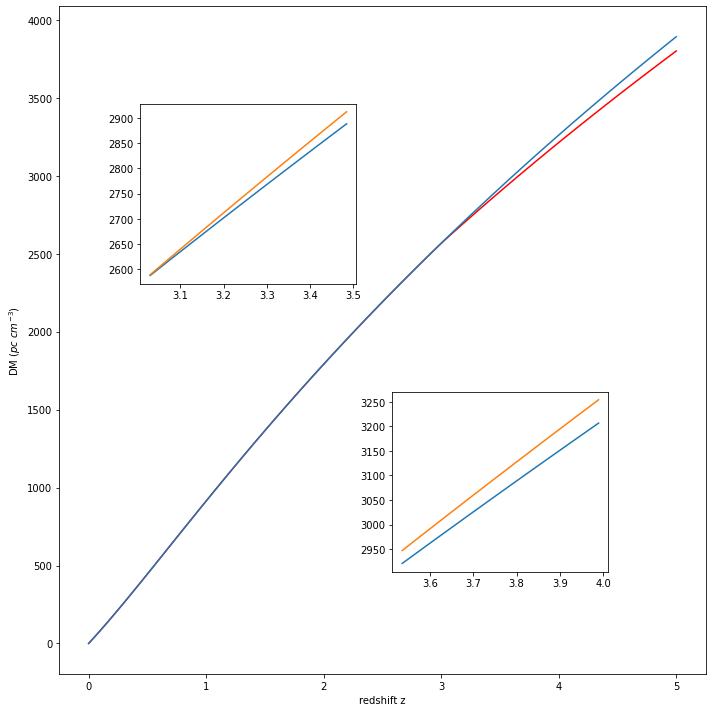

In [0]:
z = np.linspace(0, 5, 100)
reion = DM_z_reion(z, 3)
noreion = DM_z_reion(z, 10)

plt.rcParams['figure.figsize'] = [10,10]    
fig = plt.figure()
ax1 = fig.add_subplot()

ax1.plot(z, reion, 'r')
ax1.plot(z, noreion)
plt.ylabel('DM ($pc\ cm^{-3}$)')
plt.xlabel('redshift z')
# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.2, 0.6, 0.3, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])

left, bottom, width, height = [0.55, 0.2, 0.3, 0.25]
ax3 = fig.add_axes([left, bottom, width, height])


ax2.plot(z[60:70], reion[60:70])
ax2.plot(z[60:70], noreion[60:70])
ax3.plot(z[70:80], reion[70:80])
ax3.plot(z[70:80], noreion[70:80])
plt.tight_layout()
plt.show()


In [0]:
def integrand_var(z):
  a = 3.079
  b = -1.429
  c = 0.6597
  d = -0.3328
  return 1/((1+z)**2)*(a*np.exp(b*z)+c*np.exp(d*z))/np.sqrt(0.3*(1+z)**3+0.7)


def sigma_DM_IGM(z):
  sigma_DM_IGM_1p5 = 280;
  return integrate.quad(integrand_var, 0, z)[0]/integrate.quad(integrand_var, 0, 1.5)[0]*sigma_DM_IGM_1p5

def DM_IGM_fluctuation(z):
  z_arr = np.array(z)
  result = np.zeros(len(z_arr))
  for i in range(len(z_arr)):
    result[i] = np.random.normal(0, sigma_DM_IGM(z_arr[i]))
  return result
print(DM_IGM_fluctuation([0.5, 1, 1.5, 2, 2.5, 3]))
print(sigma_DM_IGM(1.5))
print(sigma_DM_IGM(3))
print(sigma_DM_IGM(6))

[ 44.95934086 222.11052952 175.08505844 144.06708886  26.44079794
 380.3879265 ]
280.0
286.43335665941885
287.25905763884316


57.759900849295704


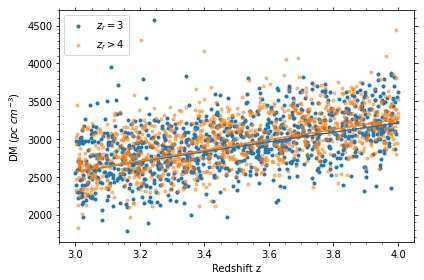

In [0]:
#data generation
def data(no_trials, z_reion, z_min, z_max):
  z=np.random.rand(no_trials)*(z_max-z_min)+z_min #Here we generate random point between z_min and z_max
  DM_output = DM_z_reion(z,z_reion) + DM_galaxy(no_trials)[0]/(1+z) + DM_IGM_fluctuation(z)
  noise = np.mean(DM_galaxy(no_trials)[0]/(1+z))
  return z, DM_output, noise

z_reion = 3. # set the reionization z here
z, DM_output, noise = data(1000, z_reion, 3, 4) #if reion happens at z = 3
#plt.scatter(z,DM_output)

z_reion2 = 10. # set the reionization z here
z2, DM_output2, noise2 = data(1000, z_reion2, 3, 4) #if reion happened much earlier (I wrote 10 here)
#plt.scatter(z2,DM_output2)

print(noise)
# Plotting
fig, axes = plt.subplots()

z_plot = np.linspace(3, 4, 100)
reion = DM_z_reion(z_plot, 3)
noreion = DM_z_reion(z_plot, 10)
axes.plot(z_plot, reion)
axes.plot(z_plot, noreion)


axes.scatter(z,DM_output, label='$z_r = 3$', marker = '.')
axes.scatter(z2,DM_output2,alpha=0.5,label='$z_r>4$', marker = '.')
axes.yaxis.set_ticks_position('both') 
axes.xaxis.set_ticks_position('both')                                                                                                                                                                                                                                                                                                                                            
axes.yaxis.set_minor_locator(AutoMinorLocator()) 
axes.xaxis.set_minor_locator(AutoMinorLocator())
axes.set_xlabel('Redshift z');axes.set_ylabel('DM ($pc \ cm^{-3}$)')
plt.legend()
plt.tight_layout()
plt.savefig('DM-1.pdf',bbox_inches='tight')
files.download('DM-1.pdf') # Use this to download the plot

In [0]:
def testing_model(P, z_reion, z_test): #define hypothesis testing function for some z_reion
  return DM_z_reion(z_test, 10)+P*(DM_z_reion(z_test, z_reion) - DM_z_reion(z_test, 10))

def Wrapper(P, z_reion, z_test, DM_test, noise): #residue vector wrapper for the above model
  return testing_model(P, z_reion, z_test) - DM_test + noise

x0=0
res_lsq = least_squares(Wrapper, x0, method='trf', args=(3, z, DM_output, noise))
print(res_lsq.x)
J= res_lsq.jac
cov = np.linalg.inv(J.T.dot(J))
print(np.sqrt(np.diagonal(cov)))

[1.13013873]
[0.00111547]


In [0]:

'''#try fitting for different variables and repeat to obtain mean and std
z_min = 3
z_max = 4
no_points = 1
no_trial = 5
sample_points = 5
P_mean = np.zeros((sample_points, sample_points))
P_min = np.zeros((sample_points, sample_points))
P_max = np.zeros((sample_points, sample_points))
P_std = np.zeros((sample_points, sample_points))
for i in range(sample_points):
  for j in range(sample_points):
    P = np.zeros(no_trial)
    for k in range (no_trial):
      z, DM_output, noise = data(no_points, 3+i/sample_points, z_min, z_max)
      res_lsq = least_squares(Wrapper, x0, method='trf', args=(3+j/sample_points, z, DM_output, noise))
      P[k] = res_lsq.x
    print(P) #raw result output
    P_mean[i,j] = np.mean(P)
    P_min[i,j] = np.min(P)
    P_max[i,j] = np.max(P)
    P_std[i,j] = np.std(P)

print(P_mean) #mean of P output
print(P_min) #minimum
print(P_max) #maximum
print(P_std) #standard deviation'''

[  3.74969995 224.03763237  -1.5925775   -0.35982983  -6.81291481]
[ 0.         -3.26674413  0.         -8.4919882   1.4219512 ]
[ 0.          1.44177346 13.54436054  0.          5.65371964]
[   0.          -13.52401564 -130.77609008    0.            4.94874201]
[  4.83543874 144.36250511  -1.7747064    0.           0.        ]
[-4.33610684 -2.22313666 11.95020185  3.5329543  -7.01439594]
[12.17426533 -0.07481385  0.         23.55464479  5.4523208 ]
[-1.04598456 -3.26223165  2.18439848  3.6846904  11.7112313 ]
[  0.         -23.8118648  -22.88060908   0.         -34.33523497]
[ 0.         12.66897403  0.          0.          0.        ]
[-6.84387344 -8.8447052   6.20824691 -2.09718748 -0.85723308]
[  0.          -7.50978174 -16.69570147  -7.79804433  -0.20301569]
[ 2.95165181  0.          0.         -5.86917919  5.15975062]
[ 0.         25.31017417  0.          0.          0.        ]
[  0.           0.           0.           0.         -55.54879024]
[ 1.51218491 -3.97696251  4.1982621

In [0]:
'''
pars = lmfit.Parameters()
pars.add_many(('a', 0.1), ('z', 3))
def Wrapper_lmfit(Par,z_test, DM_test, noise):
  return testing_model(Par['a'], Par['z'], z_test) - DM_test + noise

no_points = 10

z, DM_output, noise = data(no_points, 3, 3, 4)

mini = lmfit.Minimizer(Wrapper_lmfit, pars, fcn_args=(z, DM_output, noise))
result = mini.minimize()
for name, param in result.params.items():
    print(name)
    print(param.value)
    print(param.stderr)

#print(result.params.valuesdict()['a'])
#print(result.params.valuesdict()['z'])
'''

'''
nx_ny=10
#ci = lmfit.conf_interval(mini, result)
gr=np.zeros((nx_ny,nx_ny,10))
for i in range(10):
  z, DM_output, noise = data(no_points, 3, 3, 4)

  mini = lmfit.Minimizer(Wrapper_lmfit, pars, fcn_args=(z, DM_output, noise))
  result = mini.minimize()
  x, y, gr[:,:,i] = lmfit.conf_interval2d(mini, result, 'a','z',nx=nx_ny, ny=nx_ny, limits=((0,2),(2.4, 3.6)))

gr = np.average(gr, axis=2)
ctp = plt.contourf(x, y, gr, np.linspace(0, 1, 101))
plt.colorbar(ctp)


#lmfit.printfuncs.report_ci(ci)
'''






a
0.5768139022760158
6.406391319766374
z
3.184288576443635
4.616785263373087


"\nnx_ny=10\n#ci = lmfit.conf_interval(mini, result)\ngr=np.zeros((nx_ny,nx_ny,10))\nfor i in range(10):\n  z, DM_output, noise = data(no_points, 3, 3, 4)\n\n  mini = lmfit.Minimizer(Wrapper_lmfit, pars, fcn_args=(z, DM_output, noise))\n  result = mini.minimize()\n  x, y, gr[:,:,i] = lmfit.conf_interval2d(mini, result, 'a','z',nx=nx_ny, ny=nx_ny, limits=((0,2),(2.4, 3.6)))\n\ngr = np.average(gr, axis=2)\nctp = plt.contourf(x, y, gr, np.linspace(0, 1, 101))\nplt.colorbar(ctp)\n\n\n#lmfit.printfuncs.report_ci(ci)\n"

In [0]:
pars = lmfit.Parameters()
pars.add('z', 3)
def Wrapper_lmfit_2(Par,z_test, DM_test):
  return DM_z_reion(z_test, Par['z']) - (DM_test-275/(1+z_test))

min_num = 1 #this indicate minimum number of samples is 10
max_num = 2 #this indicate maximum number of samples is 1000
min_z = 3
max_z = 4
z_reion = 3
grid_num = 3

sigma=np.zeros(grid_num)
no_points = np.round(np.logspace(min_num, max_num, grid_num))
for j in range(grid_num):
  trials = int(np.ceil(10**max_num/no_points[j]))
  print(trials)
  std = np.zeros(trials)
  mean = np.zeros(trials)
  for i in range(trials):
    z, DM_output,noise = data(int(no_points[j]), z_reion, min_z, max_z)
    mini = lmfit.Minimizer(Wrapper_lmfit_2, pars, fcn_args=(z, DM_output))
    result = mini.minimize()
    z_result = result.params.pop('z')
    if z_result.stderr is None:
      z_result.stderr = 3
    std[i] = z_result.stderr
    mean[i] = z_result.value
  sigma[j] = np.mean(std)

print(sigma)



10
4
1
[2.44366496 0.64898649 0.35499275]


In [0]:
min_num = 1 #this indicate minimum number of samples is 10^min_num
max_num = 2 #this indicate maximum number of samples is 10^max_num
min_z = 3
max_z = 4
z_reion = 3
grid_num = 3
max_error_z = 0.2 #max. error in z = 20%

sigma=np.zeros((grid_num+1, grid_num))
for k in range(grid_num+1):
  no_points = np.round(np.logspace(min_num, max_num, grid_num))
  for j in range(grid_num):
    trials = int(np.ceil(10**max_num/no_points[j]))
    print(trials)
    std = np.zeros(trials)
    mean = np.zeros(trials)
    for i in range(trials):
      z, DM_output,noise = data(int(no_points[j]), z_reion, min_z, max_z)
      z_err = np.random.randn(len(z))*max_error_z/grid_num*k*z
      z = z+z_err
      #print(z)
      #print(np.random.randn(len(z))*max_error_z/grid_num*k)
      #print(z_err)
      mini = lmfit.Minimizer(Wrapper_lmfit_2, pars, fcn_args=(z, DM_output))
      result = mini.minimize()
      z_result = result.params.pop('z')
      if z_result.stderr is None or z_result.stderr>3:
        z_result.stderr = 3
      std[i] = z_result.stderr
      mean[i] = z_result.value
    sigma[k,j] = np.mean(std)
  
print(sigma)



10
4
1
10
4
1
10
4
1
10
4
1
[[2.08569762 0.77771334 0.2474363 ]
 [2.25485747 0.63802686 0.20771447]
 [1.3646468  0.71895715 0.11812712]
 [2.85161455 1.77221557 1.10318986]]


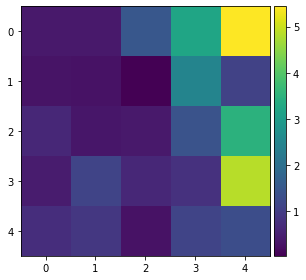

In [0]:
fig, axes = plt.subplots()
#print(np.abs(P_mean-1))
divider = make_axes_locatable(axes)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = axes.imshow(np.abs(P_mean-1))
fig.colorbar(im,cax=cax, orientation='vertical')
#plt.imshow(P_std)
plt.tight_layout()
plt.savefig('DM-2.pdf')
#files.download('DM-2.pdf')

In [0]:
u1000_1=files.upload()
#p_mean_1000 = pd.read_csv(io.BytesIO(uploaded['p_mean_1000.csv']),delimiter=',')

Saving p_mean_1000.csv to p_mean_1000 (3).csv


In [0]:
p_mean_1000 = pd.read_csv(io.BytesIO(u1000_1['p_mean_1000.csv']),delimiter=',')

# Download Plots here 

In [0]:
#files.download('DM-1.pdf')
#files.download('DM-2.pdf')

In [0]:
"""z=np.linspace(0,6,1000)


trial_3 = DM_z_reion(z, 3)
trial_6 = DM_z_reion(z, 6)

plt.plot(z ,trial_3)
plt.plot(z, trial_6)
"""

'z=np.linspace(0,6,1000)\n\n\ntrial_3 = DM_z_reion(z, 3)\ntrial_6 = DM_z_reion(z, 6)\n\nplt.plot(z ,trial_3)\nplt.plot(z, trial_6)\n'

In [0]:
"""def Fun(z_reion, z_test, DM_test):  #define a wrapper function for fitting which calculate the residue vector
  return DM_z_reion(z_test, z_reion) - DM_test

print(np.mean(Fun(3, DM_output[:,0], DM_output[:,1])))
print(np.mean(Fun(4, DM_output[:,0], DM_output[:,1])))
print(np.mean(Fun(5, DM_output[:,0], DM_output[:,1])))
print(np.mean(Fun(6, DM_output[:,0], DM_output[:,1])))
x0=np.array([5.9]) #initial guess

res_lsq = least_squares(Fun, x0, gtol=0, method='trf', args=(DM_output[:,0], DM_output[:,1]))

print(res_lsq.status)
print(res_lsq.fun)"""

"def Fun(z_reion, z_test, DM_test):  #define a wrapper function for fitting which calculate the residue vector\n  return DM_z_reion(z_test, z_reion) - DM_test\n\nprint(np.mean(Fun(3, DM_output[:,0], DM_output[:,1])))\nprint(np.mean(Fun(4, DM_output[:,0], DM_output[:,1])))\nprint(np.mean(Fun(5, DM_output[:,0], DM_output[:,1])))\nprint(np.mean(Fun(6, DM_output[:,0], DM_output[:,1])))\nx0=np.array([5.9]) #initial guess\n\nres_lsq = least_squares(Fun, x0, gtol=0, method='trf', args=(DM_output[:,0], DM_output[:,1]))\n\nprint(res_lsq.status)\nprint(res_lsq.fun)"

In [0]:
"""def Fun_noise(z_reion, z_test, DM_test):  #define a wrapper function with noise compensation
  noise = np.mean(DM_galaxy(1000))
  return DM_z_reion(z_test, z_reion) - DM_test + noise


print(np.mean(Fun_noise(3, DM_output[:,0], DM_output[:,1])))
print(np.mean(Fun_noise(4, DM_output[:,0], DM_output[:,1])))
print(np.mean(Fun_noise(5, DM_output[:,0], DM_output[:,1])))
print(np.mean(Fun_noise(6, DM_output[:,0], DM_output[:,1])))

x0=1 #initial guess
print(np.mean(Fun_noise(np.array([3]), DM_output[:,0], DM_output[:,1])))

res_lsq = least_squares(Fun_noise, x0, gtol=0, method='dogbox', args=(DM_output[:,0], DM_output[:,1]))
print(res_lsq.x)"""

"def Fun_noise(z_reion, z_test, DM_test):  #define a wrapper function with noise compensation\n  noise = np.mean(DM_galaxy(1000))\n  return DM_z_reion(z_test, z_reion) - DM_test + noise\n\n\nprint(np.mean(Fun_noise(3, DM_output[:,0], DM_output[:,1])))\nprint(np.mean(Fun_noise(4, DM_output[:,0], DM_output[:,1])))\nprint(np.mean(Fun_noise(5, DM_output[:,0], DM_output[:,1])))\nprint(np.mean(Fun_noise(6, DM_output[:,0], DM_output[:,1])))\n\nx0=1 #initial guess\nprint(np.mean(Fun_noise(np.array([3]), DM_output[:,0], DM_output[:,1])))\n\nres_lsq = least_squares(Fun_noise, x0, gtol=0, method='dogbox', args=(DM_output[:,0], DM_output[:,1]))\nprint(res_lsq.x)"